# Establishing Association Rules From UFO Sightings

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


In [3]:
data = pd.read_pickle(os.getcwd() + '/data/cleaned_reports_07202018.pkl')

In [4]:
df = data[['Shape Categories Revised']].copy()
df.columns = ['Shapes']

In [5]:
df.head()

,Shapes
0,[Changing]
1,[Light]
2,"[Light, Circle]"
3,[Light]
4,[Light]


In [6]:
binarizer = MultiLabelBinarizer() #class for getting dummies fromm multiple labels
df = df[df['Shapes'].str.len() > 1] #we only care about pairs
s = df['Shapes'] #we only care about pairs.
matrix_df = pd.DataFrame(binarizer.fit_transform(s), columns=binarizer.classes_, index=df.index).reset_index(drop=True)

In [7]:
matrix_df.head()

,Changing,Chevron,Cigar,Circle,Cone,Crescent,Cross,Cylinder,Delta,Diamond,...,Hexagon,Light,Orb,Oval,Pyramid,Rectangle,Round,Sphere,Teardrop,Triangle
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


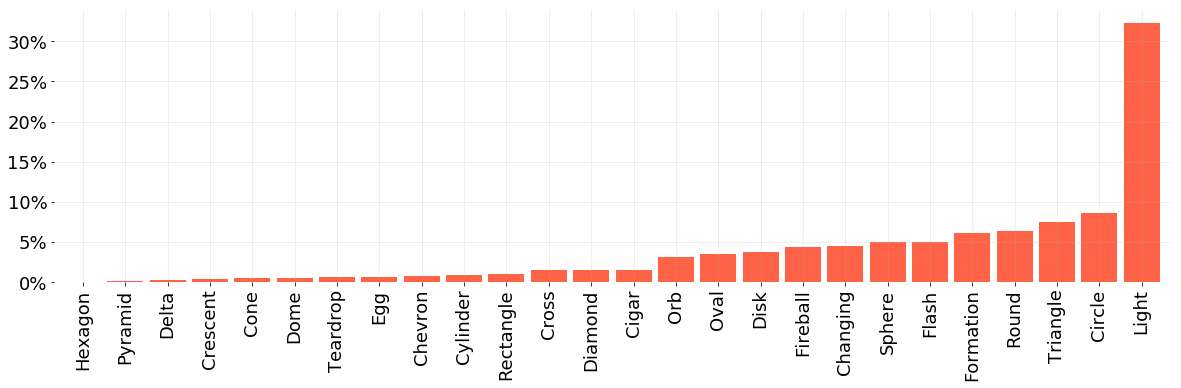

In [8]:
#CALCULATE SUPPORT FOR EACH SHAPE CATEGORY
support = {}
for shape in matrix_df.columns:
    support[shape] = np.sum(matrix_df[shape] > 0)

#PLOTTING SUPPORT VALUES
fig, ax = plt.subplots(figsize=(20,5))
for s in ax.spines: ax.spines[s].set_visible(False)
supportSorted = pd.Series(support).sort_values()
supportSorted = 100 * supportSorted / supportSorted.sum()
supportSorted.plot(kind='bar', width=0.85, fontsize=18, color='tomato',ax=ax)
ax.grid(True, alpha=0.25)
ax.set_yticklabels(['{:,.0f}%'.format(y) for y in ax.get_yticks()])
plt.show()

Distribution is tremendously skewed towards 'light'-shaped ufos, so we should drop this to glean more interesting associations. Will drop hexagon column as well due to effectively zero support.

In [9]:
matrix_df = matrix_df.drop(['Light','Hexagon'], axis=1)

Need to tally up pairs between shape categories.

In [10]:
matrix = matrix_df.as_matrix()
x, y = matrix.shape
frequencies = np.zeros((y,y))
for i in range(0, y - 1):
    for j in range(i + 1, y):
        v = matrix[:, i] * matrix[:, j]
        frequencies[i, j] = np.sum(v > 0)

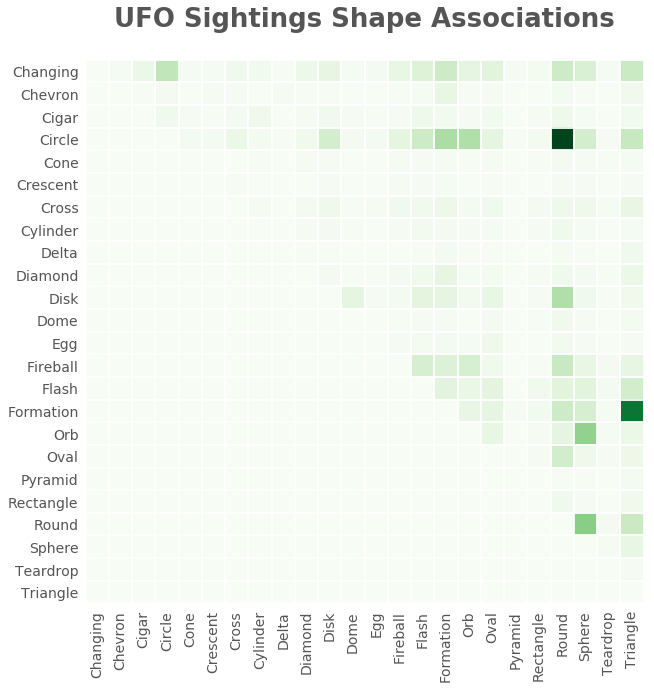

In [11]:
#HEAT MAPPING BY STATE
fig, ax = plt.subplots(figsize=(10,10))

for spine in ['top','right','bottom','left']: ax.spines[spine].set_visible(False)
ax.set_title('UFO Sightings Shape Associations', fontsize=26, fontweight='bold', color='#555555', y=1.05)

matrix = frequencies
cols = matrix_df.columns
rows = matrix_df.columns

width = len(cols)
height = len(rows)

ax.imshow(matrix, alpha=1.0, interpolation='none', aspect='auto', cmap='Greens')

# Major ticks
ax.set_xticks(np.arange(0, width, 1));
ax.set_yticks(np.arange(0, height, 1));

# Labels for major ticks
ax.set_xticklabels(cols, fontsize=14, color='#555555', rotation=90);
ax.set_yticklabels(rows, fontsize=14, color='#555555');

# Minor ticks
ax.set_xticks(np.arange(-0.5, width, 1), minor=True);
ax.set_yticks(np.arange(-0.5, height, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='#FFFFFF', linestyle='solid', linewidth=1.8)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

plt.show()

In [12]:
def pairs(matrix, minimum):
    pair_dict = {}
    loc = np.where(matrix > minimum)
    x, y = loc[0], loc[1]
    for idx, val in enumerate(x):
        i, j = x[idx], y[idx]
        pair_ = matrix_df.columns[i] + ', ' + matrix_df.columns[j]
        pairs = matrix[i, j]
        pair_dict[pair_] = pairs
    return pair_dict

In [13]:
pd.Series(pairs(matrix, minimum=500)).sort_values(ascending=False)

Circle, Round          2309.0
Formation, Triangle    1927.0
Round, Sphere          1016.0
Orb, Sphere             959.0
Circle, Formation       793.0
Disk, Round             741.0
Circle, Orb             740.0
Changing, Circle        631.0
Circle, Triangle        575.0
Fireball, Round         563.0
Changing, Triangle      554.0
Round, Triangle         537.0
Formation, Round        522.0
Changing, Formation     518.0
Circle, Flash           517.0
Changing, Round         508.0
dtype: float64

We have our frequency pairs, now we need to calculate confidence and lift values to determine what rules apply here.